# Fine tuning the siamese network

In [1]:
import keras, numpy as np, os
from models import get_siamese_model, contrastive_loss
from DataLoaders import DataLoaderContrastive, get_dataset_contrastive_with_prefetching

2024-12-18 13:51:44.412299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734519104.429127    7960 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734519104.434169    7960 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 13:51:44.451542: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
backbone_weights_path = os.path.join('Data', 'Models', 'backbone after classification', 'model.weights.h5')
siamese_model = get_siamese_model(backbone_weights_path)

I0000 00:00:1734519118.036784    7960 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5831 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


In [3]:
siamese_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 128)       │  8,903,296 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ functional_1[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,903,296 (33.96 MB)

 Trainable params: 8,893,184 (33.92 MB)

 Non-trainable params: 10,112 (39.50 KB)

In [4]:
siamese_model.compile(
    loss = contrastive_loss(),
    optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
    metrics = ['accuracy']
)

checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join('Data', 'Models', 'binary entropy model', 'model.weights.h5'),
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    monitor = 'loss'
)

early_stop = keras.callbacks.EarlyStopping(monitor = 'loss', patience = 15)
learning_rate_schedule = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 5)

In [5]:

# train_loader = DataLoaderContrastive(
#     dataset_root_path = os.path.join('Data', 'Casia Webface', 'casia-webface'),
#     batch_size = 32,
#     img_size = (128, 128),
#     positive_ratio = 0.5
# )

from sklearn.datasets import fetch_lfw_pairs

data = fetch_lfw_pairs(subset = '10_folds', resize = 1, color = True)


In [6]:
import tensorflow as tf, cv2
pairs = data['pairs']
targets = data['target']
images1, images2 = [], []

for pair in pairs:
    img1, img2 = pair
    images1.append(cv2.resize(img1, (128, 128)))
    images2.append(cv2.resize(img2, (128, 128)))

images1, images2 = np.array(images1), np.array(images2)



In [7]:
images1 = tf.data.Dataset.from_tensor_slices(images1)
images2 = tf.data.Dataset.from_tensor_slices(images2)
targets = tf.data.Dataset.from_tensor_slices(targets)

train_data = tf.data.Dataset.zip(((images1, images2), targets)).batch(32)

In [8]:
siamese_model.fit(
    x = train_data,
    epochs = 100,
    batch_size = 32,
    callbacks = [learning_rate_schedule, early_stop]
)

Epoch 1/100


/home/thoalfeqar/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_258', 'keras_tensor_259']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1734519161.264215    8033 service.cc:148] XLA service 0x7a52c80a27a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734519161.264233    8033 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-12-18 13:52:42.404055: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734519166.292675    8033 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-18 13:52:52.740163: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local me

  1/188 ━━━━━━━━━━━━━━━━━━━━ 4:02:03 78s/step - accuracy: 1.0000 - loss: 0.0034

I0000 00:00:1734519210.794667    8033 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4738 - loss: 0.3575

2024-12-18 13:54:00.254933: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_212', 16 bytes spill stores, 16 bytes spill loads

2024-12-18 13:54:00.357226: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_212_0', 328 bytes spill stores, 316 bytes spill loads

2024-12-18 13:54:00.539966: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_479', 192 bytes spill stores, 192 bytes spill loads

2024-12-18 13:54:01.048880: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_212', 4 bytes spill stores, 4 bytes spill loads

2024-12-18 13:54:01.183728: I external/local_xla/xla/stream_

188/188 ━━━━━━━━━━━━━━━━━━━━ 144s 356ms/step - accuracy: 0.4732 - loss: 0.3571 - learning_rate: 1.0000e-04
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.3488 - loss: 0.2961 - learning_rate: 1.0000e-04
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.3566 - loss: 0.2795 - learning_rate: 1.0000e-04
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.4067 - loss: 0.2692 - learning_rate: 1.0000e-04
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.5260 - loss: 0.2504 - learning_rate: 1.0000e-04
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.7039 - loss: 0.2152 - learning_rate: 1.0000e-04
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.8298 - loss: 0.1783 - learning_rate: 1.0000e-04
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.9108 - loss: 0.1407 - learning_rate: 1.0000e-04
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy:

KeyboardInterrupt: 

In [16]:
(X1, X2), y = train_loader[0]
y_pred = siamese_model.predict_on_batch([X1, X2])


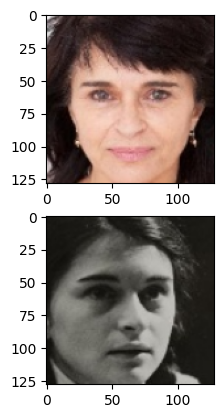

(array([[1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]]),
 array([[0.20313346],
        [0.20625038],
        [0.86352164],
        [0.25308135],
        [1.0963606 ],
        [0.4246863 ],
        [0.08287632],
        [0.20190635],
        [1.0839448 ],
        [0.3157644 ],
        [1.0398438 ],
        [0.21278355],
        [0.89068466],
        [1.0716404 ],
        [0.22907546],
        [0.27493763],
        [0.46851563],
        [0.25006926],
        [0.1683789 ],
        [1.0655432 ],
        [0.5502119 ],
        [0.54017514],
        [0.94160473],
        [0.6363575 ],
        [0.09663338],


In [17]:
from matplotlib import pyplot as plt
plt.subplot(2, 1, 1)
plt.imshow(X1[0].astype(np.uint8))
plt.subplot(2, 1, 2)
plt.imshow(X2[0].astype(np.uint8))
plt.show()
y, y_pred